In [32]:
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Dict, List, Union, Optional
import matplotlib.pyplot as plt
from IPython.display import display
from scipy import stats
import os
import datetime
import jinja2

In [103]:
class Theoretical_Ranges:
    def __init__(self, min_max_path: str, scaling_factor: float=1e-12, sheet_name:str = 'icranges'):
        self.name = os.path.splitext(os.path.basename(min_max_path))[0]
        self.df_ranges = pd.read_excel(min_max_path, sheet_name=sheet_name)
        self.df_ranges['value'] = self.df_ranges['value'].astype(float)
        self.df_ranges.species = [s.upper() for s in self.df_ranges.species]
        self.scaling_factor = scaling_factor
        self.df_scaled_ranges = self.df_ranges.select_dtypes(include='number') * self.scaling_factor
        self.bounds = self.get_bounds()
        self.rel_sigmas = self.get_sigma_dict()

    def get_sigma_dict(self) -> dict[str, float]:
        rel_sigmas = dict()
        for index, row in self.df_ranges.iterrows():
            rel_sigmas[row.species] = ((row.value*1.5-row.value/2)/8)*1e-12
        return rel_sigmas

    def get_bounds(self) -> dict[str, tuple[float, float]]:
        bounds = dict()
        for index, row in self.df_ranges.iterrows():
            if row.value < 0.1:
                lb = 1e-14
                ub = 1e-13
            else:
                lb = (row.value/2)*1e-12
                ub = (row.value*1.5)*1e-12
            bounds[row.species.upper()] = [lb, ub]
        print(bounds['TBID'])
        return bounds


In [ ]:
class Model:
    def __init__(self, model_name: str, input_species: dict[str, float], # input_species: dict[name, init_value]
                 output_species: list[str], time_points: list[float],
                 species_rng: Theoretical_Ranges, exp_vals: dict[str: list[float]],
                 stress: tuple[str: float]=('RAPOUT', 5e-5)): # dict[stress_species: init_cc] = [rap extracell.: [mol/cm^3]]
        self.rng = species_rng
        self.model_name = model_name
        self.input_species = input_species
        self.output_species = output_species
        self.time_points = time_points
        self.exp_vals = exp_vals
        self.stress = stress
        self.check_compatibility()
        self.gen_exp_data()

    def check_compatibility(self) -> None:
        for s in self.output_species:
            if s not in self.input_species.keys():
                RuntimeError('Output species not found in input')
        for s in self.input_species.keys():
            if s.upper() not in self.rng.bounds.keys():
                self.rng.bounds[s] = [0.5*self.input_species[s], 1.5*self.input_species[s]]
                print(f"Creating new entry for {s}\n")

    def gen_exp_data(self):
        self.exp_data = pd.DataFrame()
        self.exp_data['time'] = self.time_points
        for k, v in self.exp_vals.items():
            self.exp_data[k] = v

In [ ]:
class Simulation:
    def __init__(self, species_range: Theoretical_Ranges, model: Model,
                 max_digit = 4, bibtex = None):
        self.species_range = species_range
        self.model = model
        self.maxdigit = max_digit
        if bibtex is None:
            self.bibtex = self.get_bibtex('input_files/default_bibtex.txt')
        else:
            self.bibtex = self.get_bibtex()

    def get_bibtex(self, bib_txt_path=None):
        if bib_txt_path is not None:
            with open(bib_txt_path, 'r') as f:
                lines = f.readlines()
            bibtex_dictt = {}
            lines = lines[1:-1]
            for line in lines:
                name = line.split('=')[0].strip()
                content = line.split('{')[1].split('}')[0]
                bibtex_dictt[name] = content
        return bibtex_dictt

    def create_xml_files(self, output_xmls_path: str, num_of_xmls: int, xml_template_path: str) -> None:
        if not os.path.exists(output_xmls_path):
            os.makedirs(output_xmls_path)
        self.num_of_xmls = num_of_xmls
        env = jinja2.Environment(loader=jinja2.FileSystemLoader(os.path.dirname(xml_template_path)))
        self.template = env.get_template(os.path.basename(xml_template_path))

        for i in range(1, num_of_xmls+1):
            np.random.seed(i)
            self.random_ics = self.get_random_ics()
            self.get_output_sigmas()
            self.make_xml_output(i, output_xmls_path)

    def get_random_ics(self) -> dict[str, float]:
        random_ics = {}
        for key in self.model.input_species.keys():
            if self.species_range.bounds[key][0] == 0 and self.species_range.bounds[key][1] == 0:
                random_ics[key] = 1e-14
            else:
                random_ics[key] = np.random.uniform(*self.species_range.bounds[key])
        random_ics[self.model.stress[0]] = self.model.stress[1]
        random_ics["REF"] = 1.0 # even if "REF" was in the input, it still needs to be assigned 1
        return random_ics

    def get_output_sigmas(self):
        self.output_sigmas = {}
        for s in self.model.output_species:
            self.output_sigmas[s] = self.species_range.rel_sigmas[s]

    def make_xml_output(self, file_index: int, output_xmls_path: str) -> None:
        dataPoints = [self.compileDataRow(row.values) for _, row in self.model.exp_data.iterrows()]
        output = self.template.render(ics=self.random_ics, variables=self.model.output_species,
                                      dataPoints=dataPoints, bib=self.bibtex, output_sigmas=self.output_sigmas)
        padded_number = str(file_index).zfill(self.maxdigit)
        filename = f"{self.model.model_name}_{padded_number}.xml"
        with open(os.path.join(output_xmls_path, filename), 'w') as f:
            f.write(output)

    def compileDataRow(self, dataPoints):
        meas = "".join(f"<{v}>{{:.4e}}</{v}>" for v in self.model.exp_data.columns)
        return f"<dataPoint>{meas.format(*dataPoints)}</dataPoint>"

    def generate_opp_content(self, xml_folder: str, name: str, mech_file: str,
                             yaml_file: str, time_limit: int, thread_limit: int,
                             settings_tag: str, solver: str) -> str:

      mech_name = mech_file.strip('/')[-1].strip('.inp')[0]
      # Create MECHMOD section
      mechmod = f"""MECHMOD
      USE_NAME         {mech_name}
      MECH_FILE        {mech_file}
      COMPILE_cantera  {yaml_file}
      END
      """

      # Create MECHTEST section
      mechtest = f"""MECHTEST
      MECHANISM  {mech_name}
      TIME_LIMIT {time_limit}
      THREAD_LIMIT {thread_limit}
      SETTINGS_TAG {settings_tag}
      FALLBACK_TO_DEFAULT_SETTINGS

      SOLVER {solver}
      SAVE_STATES      CSV
      """

      # Add each XML file name
      for xml_idx in range(1, self.num_of_xmls+1):
          padded_number = str(xml_idx).zfill(self.maxdigit)
          mechtest += f"      NAME {xml_folder}/stressful_life_{padded_number}.xml\n"

      mechtest += "END\n"

      return mechmod + "\n" + mechtest

    def gen_opp(self, output_dir, sheet_name, opp_output_dir, mech_file: str = "7_Krisztian/mech/BCRN6.inp",
                yaml_file: str = "7_Krisztian/mech/BCRN6.yaml", time_limit: int = 50, thread_limit: int = 32,
                settings_tag: str = "systems_biology", solver: str = "cantera"):
        date = datetime.datetime.now()
        opp_content = self.generate_opp_content(output_dir, sheet_name, mech_file, yaml_file, time_limit,
                                                thread_limit, settings_tag, solver)  # Create .opp file content
        opp_filename = f"{date.year}{date.month}{date.day}_BCRN_{self.bibtex['author'].split()[0][:-1]}_{sheet_name}.opp" # Define output .opp file path
        with open(os.path.join(opp_output_dir, opp_filename), "w") as f:
            f.write(opp_content)


In [20]:
class OptimaOutput:
    def __init__(self, job_name: Union[str, Path],
                 optima_path: Optional[Union[str, Path]] = None):

        self.job_name = str(job_name)
        if optima_path == None:
            self.optima_path = Path("/home/szupernikusz/TDK/Opt/outputs")
        self.job_folder = self.optima_path / job_name
        file_path = self.job_folder / "mechanismInfo.txt"
        try:
            with open(file_path, "r") as f:
                self.mech_info = f.read()
        except Exception as e:
            raise e

In [21]:
class OptimaMechtest(OptimaOutput):
    def __init__(self, job_name: Union[str, Path],
                 input_mech: str = 'BCRN6',
                 optima_path: Optional[Union[str, Path]] = None,
                 errf_type: Union[str, List[str]] = "default"):
        super().__init__(job_name, optima_path)

        self._errf_files = {
           "default": "errfValues",
           "data_series": "errfValues_by_data_series", 
           "points": "errfValues_by_points",
           "species": "errfValues_by_species"
            }

        if (self.job_folder / "debug").exists():
            self.all_data = {}
            for csv_data in (self.job_folder / "debug").glob("*.csv"):
                try:
                    self.all_data[csv_data.stem] = pd.read_csv(csv_data)
                except Exception as e:
                    print(e)
            self.get_finer_df()

        if (self.job_folder / f"mechTestResults_{input_mech}.csv").exists():
            self.all_sheets_dP = pd.read_csv(self.job_folder / f"mechTestResults_{input_mech}.csv",  # dP as in the info in dataPoints
                                        header=None,
                                        delimiter=';',
                                        index_col=False,
                                        names=['xml', 'time_point', 'species', 'dP_val', 'sim_val'])
            self.get_coarse_df(all_sheets_dP=self.all_sheets_dP)

    def get_finer_df(self): # states_stac_0002_proper_time_p1_Rap_transz
        self.fine_time_df_dict: dic[str: pd.DataFrame()] = {}
        for k, v in self.all_data.items():
            xml_name = k.split('states_')[1].split('_p1')[0]
            v_df = v.drop(['T[K]', 'p[Pa]'], axis=1)
            aa = ['t[s]'] + [a.split('x_')[1] for a in v_df.columns[1:]]
            v_df.columns = aa
            self.fine_time_df_dict[xml_name] = v_df

    def get_coarse_df(self, all_sheets_dP):
        self.orig_time_sim_df: dict[str: pd.DataFrame()] = {}
        self.orig_time_exp_df: dict[str: pd.DataFrame()] = {}
        time_point = 0
        species = 'ilyen_species_tuti_nem_lesz'
        for idx, row in all_sheets_dP.iterrows():
            xml_name = row.xml
            sim_val = row.sim_val
            exp_val = row.dP_val

            if row.species == species:
                time_point = time_point + 1
            else:
                species = row.species
                time_point = 1
            
            if xml_name not in self.orig_time_sim_df.keys():
                self.orig_time_sim_df[xml_name] = pd.DataFrame()  # Initialize inner dict
            self.orig_time_sim_df[xml_name].loc[time_point, species] = sim_val
            if xml_name not in self.orig_time_exp_df.keys():
                self.orig_time_exp_df[xml_name] = pd.DataFrame()  # Initialize inner dict
            self.orig_time_exp_df[xml_name].loc[time_point, species] = exp_val


In [14]:
mech = OptimaMechtest("20250530_RAP2_proper_time.opp", 'Rap_transz')

In [104]:
range_file = '/home/szupernikusz/TDK/Opt/7_Krisztian/0_evaluate/input_files/reactions_ics_finalised.xlsx'
rng = Theoretical_Ranges(range_file)

[1e-14, 1e-13]


In [ ]:
input_species = {'RAP': 0, 'MTORA': 7e-10, 'REF': 1, 'RK': 0, 'FKBP12': 7e-10, 'RKMTORA': 0, 'RAPOUT': 5e-5}
output_species = ['MTORA']

exp_vals: dict[str, list[float]] =  {}
t = np.arange(0, 370, 10)
for s in output_species:
    exp_vals[s] = [cc for cc in np.ones(len(t)) * 7e-10]

model = Model('rap_transz', input_species, output_species, t, rng, exp_vals)

Creating new entry for RAP

Creating new entry for REF

Creating new entry for RK

Creating new entry for RKMTORA

Creating new entry for RAPOUT



In [92]:
sim = Simulation(rng, model)

In [93]:
sim.bibtex

{'title': 'Fine-tuning of AMPK--ULK1--mTORC1 regulatory triangle is crucial for autophagy oscillation',
 'author': 'Holczer, Marianna and Hajd',
 'journal': 'Scientific Reports',
 'volume': '10',
 'number': '1',
 'pages': '17803',
 'year': '2020',
 'publisher': 'Nature Publishing Group UK London'}

In [95]:
xml_path = '/home/szupernikusz/TDK/Opt/7_Krisztian/xml/raptest'
xml_template_path = '/home/szupernikusz/TDK/Opt/7_Krisztian/0_evaluate/input_files/xml_template_new.xml'
sim.create_xml_files(xml_path, 1, xml_template_path)

UndefinedError: 'output_sigmas' is undefined

([<matplotlib.axis.XTick at 0x7f887329d270>,
 [Text(0, 0, '0'),
  Text(10, 0, '10'),
  Text(20, 0, '20'),
  Text(30, 0, '30'),
  Text(40, 0, '40'),
  Text(50, 0, '50'),
  Text(60, 0, '60'),
  Text(70, 0, '70'),
  Text(80, 0, '80'),
  Text(90, 0, '90'),
  Text(100, 0, '100'),
  Text(110, 0, '110'),
  Text(120, 0, '120'),
  Text(130, 0, '130'),
  Text(140, 0, '140'),
  Text(150, 0, '150'),
  Text(160, 0, '160'),
  Text(170, 0, '170'),
  Text(180, 0, '180'),
  Text(190, 0, '190'),
  Text(200, 0, '200'),
  Text(210, 0, '210'),
  Text(220, 0, '220'),
  Text(230, 0, '230'),
  Text(240, 0, '240'),
  Text(250, 0, '250'),
  Text(260, 0, '260'),
  Text(270, 0, '270'),
  Text(280, 0, '280'),
  Text(290, 0, '290'),
  Text(300, 0, '300'),
  Text(310, 0, '310'),
  Text(320, 0, '320'),
  Text(330, 0, '330'),
  Text(340, 0, '340'),
  Text(350, 0, '350'),
  Text(360, 0, '360')])

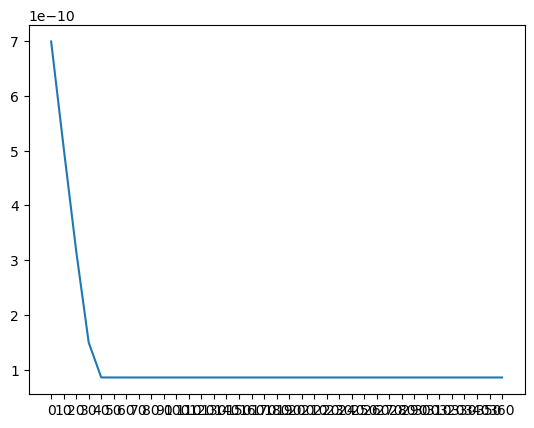

In [ ]:

plt.plot(t, mech.orig_time_sim_df['stac_0002_proper_time'])